<a href="https://colab.research.google.com/github/nutorbit/bandit/blob/main/bandit/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Armed Bandit

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from abc import ABC, abstractmethod
from typing import List, Callable, Dict
from tqdm import trange

# Environment

In [ ]:
class SlotMachine:
    """
    A simple bernoulli slot machine simulation

    Args:
        reward_rates: the percentage of jackpot for each particular slot
        seed: random seed
    """

    def __init__(self, reward_rates: List = [0.2, 0.2, 0.3], seed: int = 123):
        self.reward_rates = reward_rates
        self.n_slots = len(reward_rates)
        self.rng = np.random.default_rng(seed)
        self.history = {}
        self.reset()

    @property
    def timesteps(self) -> int:
        return len(self.history["rewards"])

    def reset(self):
        self.history = {"rewards": [], "action": []}

    def get_performance_report(self) -> Dict:
        rewards = np.array(self.history["rewards"])
        action = np.array(self.history["action"])
        best_action = rewards.argmax(axis=1)

        indices = np.arange(self.timesteps).astype(int)

        reward_action = rewards[indices, action]
        best_reward_action = rewards[indices, best_action]

        return {
            "total_timesteps": self.timesteps,
            "total_reward": reward_action.sum(),
            "cummulative_reward": reward_action.cumsum(),
            "cummulative_regret": (best_reward_action - reward_action).cumsum()
        }

    def pull(self, slot_id: int) -> int:
        assert slot_id < self.n_slots, \
        f"slot_id should be less than {self.n_slots}"

        s = self.rng.uniform(size=self.n_slots)
        rewards = (s <= self.reward_rates).astype(int)
        self.history["rewards"].append(rewards)
        self.history["action"].append(slot_id)
        return rewards[slot_id]


# Agent

In [ ]:
class BaseAgent(ABC):
    """
    Base agent class
    """

    def __init__(self):
        self.history = {"reward": [], "action": []}

    @property
    def timesteps(self) -> int:
        return len(self.history["reward"])

    @abstractmethod
    def get_action(self) -> int:
        pass

    def save_feedback(self, action: int, reward: int):
        self.history["reward"].append(reward)
        self.history["action"].append(action)

In [ ]:
class NaiveAgent(BaseAgent):
    """
    An agent who only takes one specific action.

    Args:
        action: action
    """

    def __init__(self, action: int):
        super().__init__()
        self.action = action

    def get_action(self) -> int:
        return self.action


class RandomAgent(BaseAgent):
    """
    A random agent

    Args:
        n_actions: number of possible actions
        seed: random seed
    """

    def __init__(self, n_actions: int, seed: int = 123):
        super().__init__()
        self.n_actions = n_actions
        self.rng = np.random.default_rng(seed)

    def get_action(self) -> int:
        return self.rng.integers(0, self.n_actions)

# Helper functions

In [ ]:
def plot_regret(*args, **kwargs):
    """
    Plot cummulative regret from environment reports
    """

    fig, ax = plt.subplots(figsize=(10, 7))

    for i, report in enumerate(args):
        _ = ax.plot(
            report["cummulative_regret"], 
            label=i if "names" not in kwargs else kwargs["names"][i]
        )

    _ = ax.set_xlabel("timesteps")
    _ = ax.set_ylabel("cummulative regret")
    _ = plt.legend(loc="lower right")


def test_agent(
    agent: BaseAgent, 
    n: int,
    reward_rates: List[float] = [0.1, 0.2, 0.3], 
    seed: int = 123) -> Dict:
    """
    Test an agent in environment

    Args:
        agent: agent instance
        n: number of trials
        reward_rates: the percentage of jackpot for each particular slot
        seed: random seed

    Returns:
        result report
    """
    
    env = SlotMachine(reward_rates, seed=seed)

    for _ in trange(n):
        act = agent.get_action()
        rew = env.pull(act)
        agent.save_feedback(act, rew)

    return env.get_performance_report()

# Experiment

In [ ]:
REWARD_RATES = [0.2, 0.2, 0.3]
N_ACTIONS = len(REWARD_RATES)
TOTAL_TIMESTEPS = 1_000
SEED = 123

## Pulling only one specific action

In [ ]:
rep0 = test_agent(
    agent=NaiveAgent(0), 
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

rep1 = test_agent(
    agent=NaiveAgent(1),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

rep2 = test_agent(
    agent=NaiveAgent(2),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

rep_random = test_agent(
    agent=RandomAgent(3),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:00<00:00, 59998.34it/s]


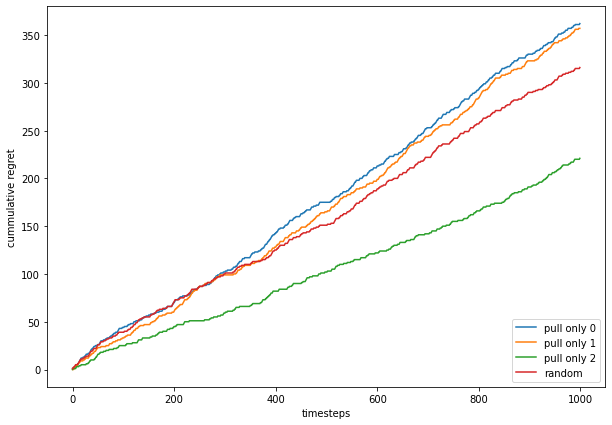

In [ ]:
plot_regret(rep0, rep1, rep2, rep_random, names=["pull only 0", "pull only 1", "pull only 2", "random"])

## Epsilon-greedy

In [ ]:
class GreedyAgent(BaseAgent):
    """
    A greedy agent who takes only action with highest expected reward

    Args:
        n_actions: number of possible actions
    """

    def __init__(self, n_actions: int):
        super().__init__()
        self.n_actions = n_actions
        self.initilize_history()

    def initilize_history(self):
        for act in range(self.n_actions):
            self.history["reward"].append(1 + np.random.rand())
            self.history["action"].append(act)

    def calculate_expected_reward(self) -> pd.DataFrame:
        df = pd.DataFrame(self.history)
        expected_reward_action = df.groupby("action")["reward"].mean()
        return expected_reward_action.sort_values(ascending=False)

    def get_action(self) -> int:
        expected_reward_action = self.calculate_expected_reward()
        best_action = expected_reward_action.index[0]
        return best_action


class EpsilonGreedyAgent(GreedyAgent):
    """
    An epsilon greedy agent

    Args:
        n_actions: number of possible actions
        epsilon: epsilon hyperparameter
        seed: random seed
    """

    def __init__(self, n_actions: int, epsilon: float = 0.2, seed: int = 123):
        super().__init__(n_actions)
        self.epsilon = epsilon
        self.rng = np.random.default_rng(seed)

    def get_action(self) -> int:
        if self.rng.random() <= self.epsilon:
            action = self.rng.integers(0, self.n_actions)
        else:
            action = super().get_action()
        return action

In [ ]:
rep_es = test_agent(
    agent=EpsilonGreedyAgent(N_ACTIONS, epsilon=0.2),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:01<00:00, 736.21it/s]


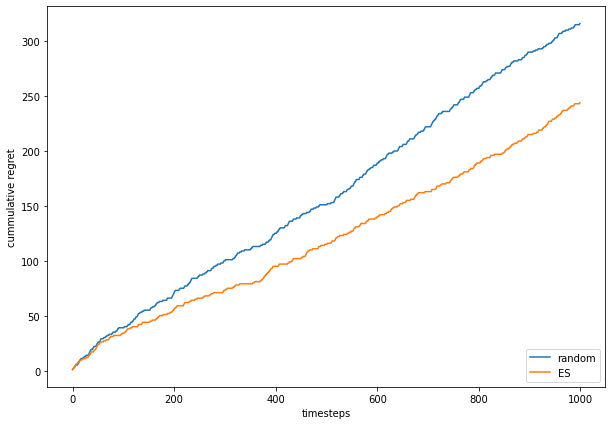

In [ ]:
plot_regret(rep_random, rep_es, names=["random", "ES"])

## Explore-then-commit

In [ ]:
class ETCAgent(GreedyAgent):
    """
    A Explore-Then-Commit (ETC) agent

    Args:
        n_actions: number of possible actions
        n_explore: number of timesteps for exploration 
        seed: random seed
    """

    def __init__(self, n_actions: int, n_explore: int, seed: int = 123):
        super().__init__(n_actions)
        self.n_explore = n_explore
        self.rng = np.random.default_rng()

    def get_action(self) -> int:
        if self.timesteps <= self.n_explore:
            action = self.rng.integers(0, self.n_actions)
        else:
            action = super().get_action()
        return action

In [ ]:
rep_etc = test_agent(
    agent=ETCAgent(N_ACTIONS, n_explore=200),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:01<00:00, 711.12it/s]


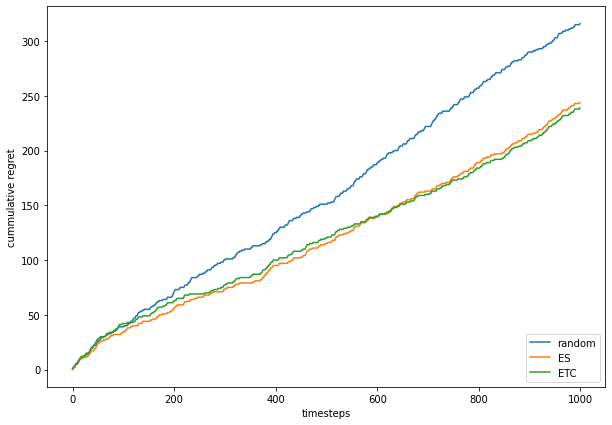

In [ ]:
plot_regret(rep_random, rep_es, rep_etc, names=["random", "ES", "ETC"])

## Upper Confidence Bound

In [ ]:
class UCBAgent(GreedyAgent):
    """
    An Upper Confidence Bound agent

    Args:
        n_actions: number of possible actions
        c: hyperparamer
    """

    def __init__(self, n_actions: int, c: float = 0.01):
        super().__init__(n_actions)
        self.c = c

    def calculate_expected_reward(self) -> pd.DataFrame:
        df = pd.DataFrame(self.history)
        expected_reward_action = df.groupby("action")["reward"].mean()
        n_action = df.groupby("action")["reward"].count()
        expected_reward_action += self.c * np.sqrt(np.log(self.timesteps) / n_action)
        return expected_reward_action.sort_values(ascending=False)

In [ ]:
rep_ucb = test_agent(
    agent=UCBAgent(N_ACTIONS),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:02<00:00, 367.21it/s]


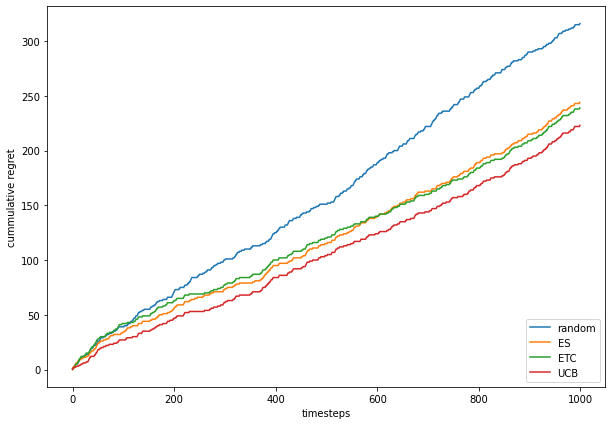

In [ ]:
plot_regret(rep_random, rep_es, rep_etc, rep_ucb, names=["random", "ES", "ETC", "UCB"])

## Thompson sampling

In [ ]:
class TSAgent(GreedyAgent):
    """
    A Thompson Sampling agent with Beta distribution

    Args:
        n_actions: number of possible actions
        c: hyperparamer
    """

    def __init__(self, n_actions: int, c: float = 0.01, seed: int = 123):
        super().__init__(n_actions)
        self.c = c
        self.rng = np.random.default_rng(seed)

    def calculate_expected_reward(self) -> pd.DataFrame:
        df = pd.DataFrame(self.history)
        n_action = df.groupby("action")["reward"].count()
        n_success = df.groupby("action")["reward"].sum()
        n_failure = n_action - n_success
        expected_reward_action = self.rng.beta((n_success + 1) / self.c, (n_failure + 1) / self.c)
        return pd.Series(expected_reward_action, index=n_action.index).sort_values(ascending=False)

In [ ]:
rep_ts = test_agent(
    agent=TSAgent(N_ACTIONS),
    n=TOTAL_TIMESTEPS, 
    reward_rates=REWARD_RATES,
    seed=SEED
)

100%|██████████| 1000/1000 [00:08<00:00, 123.08it/s]


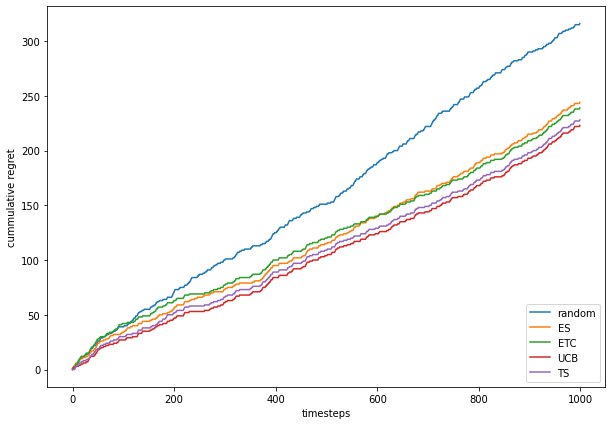

In [ ]:
plot_regret(rep_random, rep_es, rep_etc, rep_ucb, rep_ts, names=["random", "ES", "ETC", "UCB", "TS"])